In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Calcul de la divergence bidimensionelle
"""
DataFolder="C:/Users/Julie_000/Desktop/Stage/Data" 

# Importation des librairies

In [2]:
# Importation des librairies
from mat4py import loadmat #pour charger des .mat
import matplotlib.pyplot as plt # pour tracer les figures
import os # pour modifier le dossier de travail
import numpy as np # pour travailler avec des array
from pathlib import Path # Pour rendre les Path compatibles entre Mac et Windows
from matplotlib import rc #Les trois prochaines lignes pour que Ã§a ressemble Ã  latex
rc('font', size=16)
rc('text', usetex=True)

import matplotlib.cm as cm #colormaps
from matplotlib.colors import Normalize #Pour l'utilisation des couleurs dans quiver

import scipy as sc #pour l'analyse
from matplotlib.ticker import MaxNLocator #pour les courbes de niveau
from scipy.ndimage import gaussian_filter #Filtrage gaussien

colormap2=cm.PiYG#colormap

# Champs bidimensionnels de vitesse by Clément
## Définition des fonctions

In [3]:
# Definition des fonctions
def PIV(prof,manips): 
    """retourne les données des plans pour la bonne profondeur"""
    
    if prof==5:
        piv=manips['piv5']
    elif prof==10:
        piv=manips['piv10']
    elif prof==15:
        piv=manips['piv15']
    else:
        return("prof n'a pas une valeur acceptable")   
    return(piv)

def donnees(prof,plan,manips):
    """Retourne les tableaux de données pour le plan choisi de la profondeur donnée"""
    
    piv=PIV(prof,manips)
    u=np.array(piv[plan]['u'])
    v=np.array(piv[plan]['v'])
    x=np.array(piv[plan]['x'])
    y=np.array(piv[plan]['y'])
    return(u,v,x,y)

## Chargement des données

In [4]:
# Chargement des données:
os.chdir(Path(DataFolder)) # se place dans le dossier où est rangée la manip
manips=loadmat('PIVnagseul.mat') # Charge les données dans la variable manip

prof=10 # Choisi sur quelle profondeur d'eau travailler (5, 10 ou 15 mm)
plan=2
    
u,v,x,y=donnees(prof, plan, manips)
velocity=np.sqrt(u**2+v**2)


## Plot du champ de vitesse d'un plan choisi pour une profondeur donnée
### Fonction de tracé

In [5]:
def plot_champ_vitesse(u,v,x,y,title):
    "Fonction de tracé du champ de vitesse"
    # Pour mieux les représenter, Clément bidouille la colormap
    velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
    colors = velocity
    colors[velocity>velmax]=velmax
    colormap=cm.magma#colormap je crois que cette commande ne fonctionne pas
    norm = Normalize()
    norm.autoscale(colors)

    #plot   
    fig,ax=plt.subplots(num=title)
    im=ax.quiver(x,y,u/velocity,v/velocity,colors)
    fig.colorbar(im, ax=ax)  #pour la barre de couleur
    
    fig.suptitle(title,fontsize=16)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

### Tracé

C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


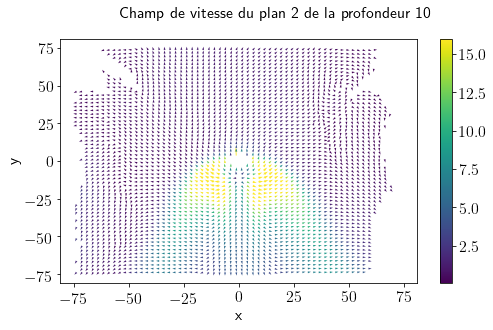

In [6]:
#%matplotlib notebook
plt.rcParams['figure.figsize'] = [8,4.5]
plot_champ_vitesse(u,v,x,y,"Champ de vitesse du plan 2 de la profondeur 10")

# Calcul de la divergence bidimensionnelle

## Approche naïve : différencier sans lisser

### Définition des fonctions


In [7]:
#Définition des fonctions

def deriv(y,x,axis):
    """Dérive un tableau 2D y par rapport à x suivant un axe donné"""
    if axis==0:
        return((y[1:,:]-y[:-1,:])/(x[1:,:]-x[:-1,:]))#Donc là le tableau est de taille (n-1,n)
    if axis==1:
        return((y[:,1:]-y[:,:-1])/(x[:,1:]-x[:,:-1]))#Donc là le tableau est de taille (n,n-1)
    return("deriv ne fonctionne que pour des tableaux 2D")
    

def abcisse(x,axis):
    """somme discrète x[i+1]+x[i]/2 suivant un axe donné"""
    if axis==0:
        return((x[1:,:]+x[:-1,:])/2)
    if axis==1:
        return((x[:,1:]+x[:,:-1])/2)
    return("abcisse ne fonctionne que pour des tableaux 2D")
        
    
def good_shape(a):
    "remise à la bonne shape des tableaux a et b pour pouvoir ensuite les sommer"
    "Ne fonctionne que dans ce cas précis avec des tableaux (n,n-1) et (n-1,n) et donne un tableau (n-1,n-1)"
    #donc on perd des données, je ne sais pas comment faire autrement...
    n=np.max(np.shape(a))
    if np.shape(a)[0]==n:
        return(a[:-1,:])
    if np.shape(a)[1]==n:
        return(a[:,:-1])
    return("les dimensions des array ne conviennent pas pour l'usage de good_shape, ou problème avec n")
 
    
def divergence2D(a,b):
    "juste somme d'array"
    if np.shape(a)==np.shape(b):
        return(a+b)
    return("les array n'ont pas la bonne shape")

### Chargement des tableaux

In [8]:
"Dérivation"
du,dv=deriv(u,x,1),deriv(v,y,0)
dx,dy=abcisse(x,1),abcisse(y,0)

"Remise à la bonne taille"
du,dv=good_shape(du),good_shape(dv)
dx,dy=good_shape(dx),good_shape(dy)

"somme des tableaux"
div = divergence2D(du,dv)
print(np.shape(dx))
print(np.max(div),np.min(div),np.mean(div),np.std(div))
vmin,vmax=np.max(div),np.min(div)

(59, 59)
16.095015991682782 -11.845523747942098 0.01010813884451311 0.7041343297871878


### Premier plot
#### Fonction de tracé

In [9]:
def plot_divergence(div,dx,dy,title):
    "Tracé des divergences et champ pour ordre de filtrage différents"
    #norme
    vmax,vmin=np.max(div),np.min(div)
    norm=Normalize(vmin=vmin, vmax=vmax)
    #norm = Normalize(vmin=vmin,vmax=vmax)
    #norm.autoscale(colors_div)

    #plot 
    fig,ax=plt.subplots(nrows=1,num=title)
    im=ax.pcolormesh(x,y,div,cmap=colormap2,norm=norm)
    fig.colorbar(im, ax=ax)
    plt.xlabel("x")
    plt.ylabel("y")

    fig.tight_layout(pad=3.2)
    fig.suptitle(title,fontsize=20)
    plt.show()

#### Plot

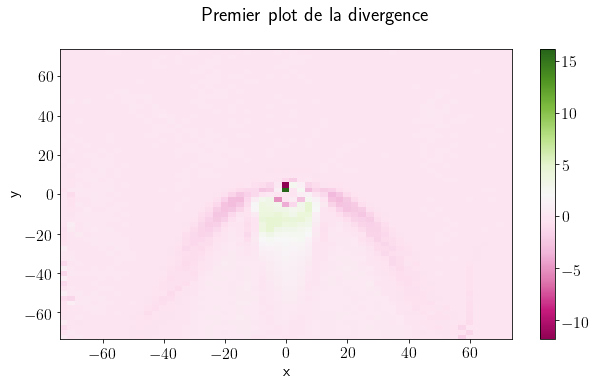

16.095015991682782 -11.845523747942098 0.01010813884451311 0.7041343297871878


In [10]:
#%matplotlib notebook
plt.rcParams['figure.figsize'] = [10,6]
plot_divergence(div,dx,dy,"Premier plot de la divergence")
print(np.max(div),np.min(div),np.mean(div),np.std(div))

On peut encore améliorer la représentation de ces données

## Représentation et affinage
### Superposition du nageur

Ici le but est d'enlever les données qui ne correspondent à rien sous le nageur. On enlève donc une zone de 5x5mm^2 soit donc 12x12 pixels centrée en 0. Je remplace cette zone par des 0, ce qui devrait apparaître blanc et correspond à peu près à la moyenne

#### Définition des fonctions

In [11]:
def masque_carre(a):
    "Enlève les données sous le nageur (forme de carré)"
    b=a
    shape=np.shape(b)
    if np.size(shape)==2:#cas la plupart du temps
        b[27:33,27:33]=np.zeros((6,6))
        
    elif np.size(shape)==3:#pour gérer cas divergence/filtrage/masque
        l=shape[0]
        for i in range(l):
            b[i,27:33,27:33]=np.zeros((6,6))
    return(b)

def masque(a):
    "applique un masque rond"
    b=a
    r=np.sqrt(dx**2+dy**2)
    shape=np.shape(b)
    if np.size(shape)==2:
        if shape[0]==59:
            return(np.where(r>6,b,0))
        elif shape[0]==60:
            r=np.sqrt(x**2+y**2)
            return(np.where(r>6,b,0))
    elif np.size(shape)==3:#pour gérer cas divergence/filtrage/masque
        l=shape[0]
        if shape[1]==59:
            for i in range(l):
                b[i,:,:]=np.where(r>6,b[i,:,:],0)
            return(b)
        elif shape[1]==60:
            r=np.sqrt(x**2+y**2)
            for i in range(l):
                b[i,:,:]=np.where(r>6,b[i,:,:],0)
            return(b)

#### Chargement des tableaux

In [12]:
div_masque=masque(div)
div = divergence2D(du,dv) #Je ne comprends pas pourquoi j'ai besoin de cette ligne pour ne pas écraser div

#ligne pour voir si div et div_masque sont toujours différents
print("div et div_masque sont identiques : {}".format(np.allclose(div,div_masque)))

div et div_masque sont identiques : False


#### Plot

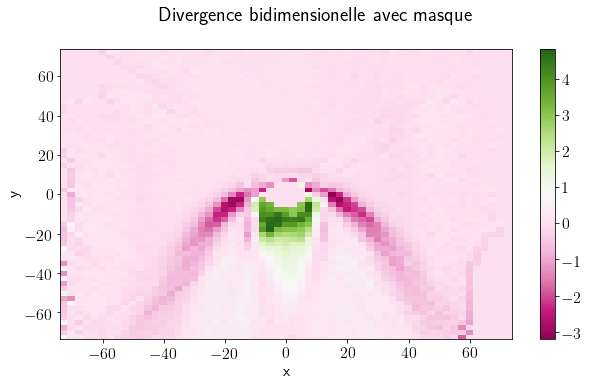

In [13]:
#%matplotlib notebook
plt.rcParams['figure.figsize'] = [10,6]
plot_divergence(div_masque,dx,dy,"Divergence bidimensionelle avec masque")

La valeur de r choisie pour le masque est obtenue en tatonnant : par diffusion de la lumière les données autour du nageur sont aussi non significatives. Le masque est-il assez grand ?

### Courbes de niveau
Pour améliorer encore la représentation, j'ajoute des courbes de niveau
#### Fonction de tracé

In [14]:
def plot_courbe_de_niveau(div0,div1,dx,dy,title):
    "Tracé de 2 divergences avec des courbes de niveau"
    #résolution (changer nbins)
    levels0 = MaxNLocator(nbins=25).tick_values(div0.min(), div0.max())
    levels1 = MaxNLocator(nbins=25).tick_values(div1.min(), div1.max())
    
    #plot
    fig, (ax0,ax1) = plt.subplots(ncols=2)
    
    cf0 = ax0.contourf(dx,dy,div0,levels=levels0, cmap=colormap2)
    fig.colorbar(cf0, ax=ax0)
    ax0.set_title('Divergence avec courbes de niveau')
    ax0.set_xlabel('x')
    ax0.set_ylabel('y')

    cf1 = ax1.contourf(dx,dy,div1,levels=levels1, cmap=colormap2)
    fig.colorbar(cf1, ax=ax1)
    ax1.set_title('Divergence avec courbes de niveau et masque')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    
    plt.tight_layout(pad=4)
    fig.suptitle(title,fontsize=20)
    plt.show()

#### Plot

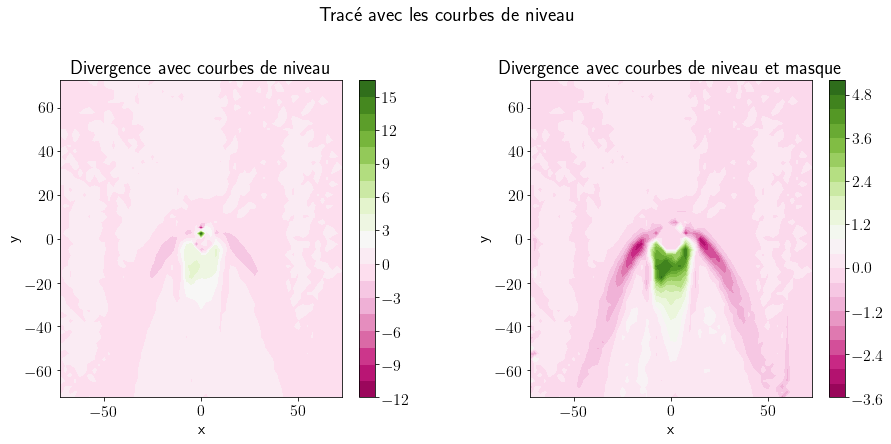

In [15]:
#%matplotlib notebook
plt.rcParams['figure.figsize'] = [14,7]
plot_courbe_de_niveau(div,div_masque,dx,dy,"Tracé avec les courbes de niveau")

### Ajout champ de vitesse
superposition du champ de vitesse sur la divergence
#### Fonction de tracé

In [16]:
def plot_superposition2(div,title):
    vmax,vmin=np.max(div),np.min(div)
    norm=Normalize(vmin=vmin, vmax=vmax)
    colors_div = div
    levels = MaxNLocator(nbins=20).tick_values(vmin, vmax)

    fig,(ax0,ax1)=plt.subplots(nrows=2)
    #ax0 avec colormap
    cf0 = ax0.contourf(dx,dy,div,levels=levels, cmap=colormap2)
    fig.colorbar(cf0, ax=ax0)
    im0=ax0.quiver(x[::2,::2],y[::2,::2],u[::2,::2]/velocity[::2,::2],v[::2,::2]/velocity[::2,::2],colors_div[::2,::2])
    fig.colorbar(im0, ax=ax0)

    ax0.set_title('Superposition avec colormap')
    ax0.set_xlabel('x')
    ax0.set_ylabel('y')
    
    #ax1 sans colormap
    cf1= ax1.contourf(dx,dy,div_masque,levels=levels, cmap=colormap2)
    fig.colorbar(cf1, ax=ax1)
    im1=ax1.quiver(x[::2,::2],y[::2,::2],u[::2,::2]/velocity[::2,::2],v[::2,::2]/velocity[::2,::2],color='k',scale=50)

    ax1.set_title('Superposition sans colormap')

    plt.suptitle(title, fontsize=20)
    plt.tight_layout(pad=3)
    plt.show()

#### Plot

C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


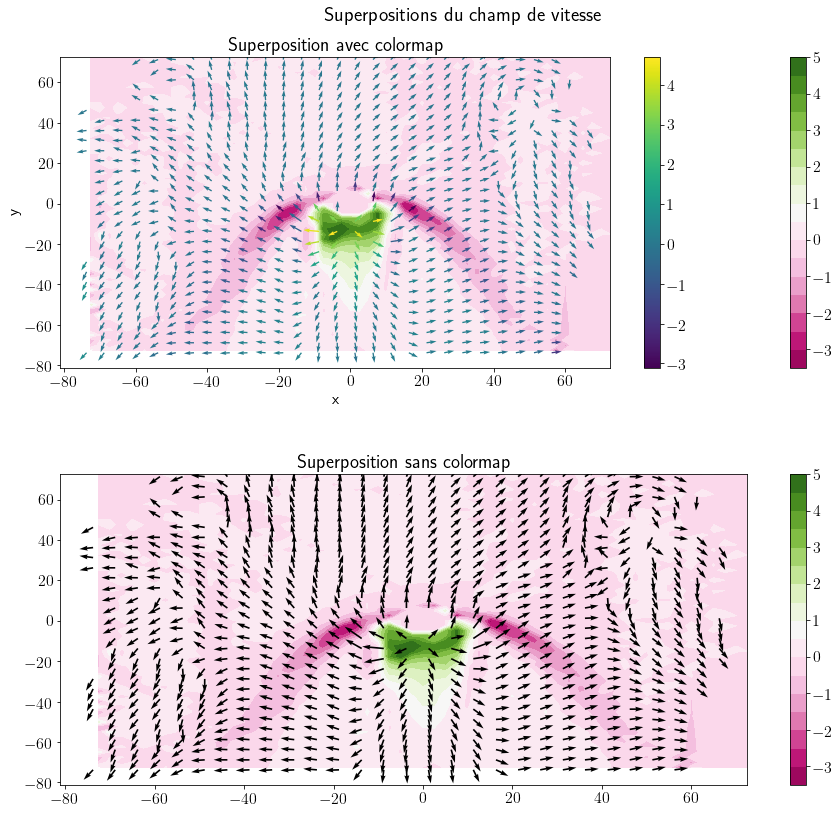

In [17]:
#%matplotlib notebook
plt.rcParams['figure.figsize'] = [14,12]
plot_superposition2(div_masque,"Superpositions du champ de vitesse")

lignes de champ peut-être à tenter

# Application d'un Filtre Gaussien
## Définition des fonctions
#### Fonctions d'analyse

In [18]:
#définition des fonctions mathématiques

def masque_puis_filtregauss(a,sigma):
    "Applique le masque puis le filtre gaussien et s'adapte à la taille de sigma"
    if np.size(sigma)==1:
        return(gaussian_filter(masque(a),sigma))
    else :
        return("sigma n'a pas la bonne taille")

    

def filtregauss_puis_masque(a,sigma):
    "Applique le filtre gaussien puis le masque et s'adapte à la taille de sigma"
    if np.size(sigma)==1:
        return(masque(gaussian_filter(a,sigma)))
    else :
        return("sigma n'a pas la bonne taille")
    
    

def Filtres(sigmas,div, ordre) :
    "Tableau des divergence filtrées suivant l'odre donné : 0 pour le masque d'abord, 1 pour le filtre d'abord, 2 sans masque"
    #boucle de création des tableaux
    l=np.shape(sigmas)[0]
    n=np.shape(div)[0]
    Filtres=np.zeros((l,n,n))#création du tableau de tableau
    if ordre==0:
        for i in range(np.shape(sigmas)[0]):
            Filtres[i]=masque_puis_filtregauss(div,sigmas[i])
        return(Filtres)
    
    elif ordre==1:
        for i in range(np.shape(sigmas)[0]):
            Filtres[i]=filtregauss_puis_masque(div,sigmas[i])
        return(Filtres)
    
    elif ordre==2:
        for i in range(np.shape(sigmas)[0]):
            Filtres[i]=gaussian_filter(div,sigmas[i])
        return(Filtres)
    return("order n'a pas la bonne valeur")
               

#### Fonctions de tracés

In [19]:
#définitions des fonctions de tracés

def plot_applications_filtre(div_filter0,div_filter1,div_filter2,title):
    "Fonction pour plot la divergence avec différents paramètres"
    #norme
    extremums=np.array([np.max(div_filter1),np.min(div_filter1),np.max(div_filter2),np.min(div_filter2)])
    vmax,vmin=np.max(extremums),np.min(extremums)
    norm=Normalize(vmin=vmin, vmax=vmax)
    levels0 = MaxNLocator(nbins=25).tick_values(div_filter0.min(), div_filter0.max())
    levels1 = MaxNLocator(nbins=25).tick_values(vmin,vmax)
    
    fig, (l0,l1,l2) = plt.subplots(nrows=3,ncols=2,num=title)
    #l0 : Brut
    im0=l0[0].pcolormesh(x,y,div_filter0,cmap=colormap2)
    l0[0].set_title("Brut")
    fig.colorbar(im0,ax=l0[0])
    im1 = l0[1].contourf(dx,dy,div_filter0,levels=levels1, cmap=colormap2)
    l0[1].set_title("Brut avec courbe de niveau")
    fig.colorbar(im1,ax=l0[1])
    #l1 : avec masque0
    im2=l1[0].pcolormesh(x,y,div_filter1,cmap=colormap2)
    l1[0].set_title("Masque puis filtrage, brut")
    fig.colorbar(im2,ax=l1[0])
    im3 = l1[1].contourf(dx,dy,div_filter1,levels=levels0, cmap=colormap2,norm=norm)
    l1[1].set_title("Masque puis filtrage, courbes de niveau")
    fig.colorbar(im3,ax=l1[1])
    #l1 : avec masque1
    im4=l2[0].pcolormesh(x,y,div_filter2,cmap=colormap2)
    l2[0].set_title("Filtrage puis masque")
    fig.colorbar(im4,ax=l2[0])
    im5 = l2[1].contourf(dx,dy,div_filter2,levels=levels0, cmap=colormap2,norm=norm)
    l2[1].set_title("Filtrage puis masque, courbes de niveau")
    fig.colorbar(im5,ax=l2[1])
    
    

    fig.tight_layout(pad=2.5)
    fig.suptitle(title,fontsize=16)
    plt.show()
    
    
    
def plot_differents_filtrages(Filtres,sigmas,n,title):
    "Fonction de tracé de filtres pour n=4 sigmas différents"
    if n==4:
        #norme
        vmax,vmin=np.max(Filtres),np.min(Filtres)
        norm=Normalize(vmin=vmin, vmax=vmax)
        levels = MaxNLocator(nbins=25).tick_values(vmin,vmax)
        
        fig, (l0,l1,l2,l3) = plt.subplots(nrows=4,ncols=2,num=title)
        #l0
        im0=l0[0].pcolormesh(x,y,Filtres[0],cmap=colormap2,norm=norm)
        l0[0].set_title("sigma={} brut".format(sigmas[0]))
        fig.colorbar(im0,ax=l0[0])
        im1 = l0[1].contourf(dx,dy,Filtres[0],levels=levels, cmap=colormap2,norm=norm)
        l0[1].set_title("sigma={} courbes de niveau".format(sigmas[0]))
        fig.colorbar(im1,ax=l0[1])
        #l1
        im2=l1[0].pcolormesh(x,y,Filtres[1],cmap=colormap2,norm=norm)
        l1[0].set_title("sigma={} brut".format(sigmas[1]))
        fig.colorbar(im2,ax=l1[0])
        im3 = l1[1].contourf(dx,dy,Filtres[1],levels=levels, cmap=colormap2,norm=norm)
        l1[1].set_title("sigma={} courbes de niveau".format(sigmas[1]))
        fig.colorbar(im3,ax=l1[1])
        #l2
        im4=l2[0].pcolormesh(x,y,Filtres[2],cmap=colormap2,norm=norm)
        l2[0].set_title("sigma={} brut".format(sigmas[2]))
        fig.colorbar(im4,ax=l2[0])
        im5 = l2[1].contourf(dx,dy,Filtres[2],levels=levels, cmap=colormap2,norm=norm)
        l2[1].set_title("sigma={} courbes de niveau".format(sigmas[2]))
        fig.colorbar(im5,ax=l2[1])
        #l3
        im6=l3[0].pcolormesh(x,y,Filtres[3],cmap=colormap2,norm=norm)
        l3[0].set_title("sigma={} brut".format(sigmas[3]))
        fig.colorbar(im6,ax=l3[0])
        im7 = l3[1].contourf(dx,dy,Filtres[3],levels=levels, cmap=colormap2,norm=norm)
        l3[1].set_title("sigma={} courbes de niveau".format(sigmas[3]))
        fig.colorbar(im7,ax=l3[1])
        
        
        fig.tight_layout(pad=3.2)
        fig.suptitle(title,fontsize=16)
        plt.show()
        
    else:
        print("Tu n'as pas n=4")

## Application du filtre sur la divergence
### Application à différents endroits
#### Constitution des tableaux

In [20]:
#choix de sigma
sigma=0.5

#Chargement des tableaux
div_filter0=gaussian_filter(div,sigma) #on applique sur div original
div_filter1=masque_puis_filtregauss(div,sigma) #sur div avec masque
div_filter2=filtregauss_puis_masque(div,sigma)#D'abord sur div original puis on applique le masque


div = divergence2D(du,dv) #Je ne comprends pas pourquoi j'ai besoin de cette ligne pour ne pas écraser div
#lignes pour voir si div et div_masque sont toujours différents
print(np.max(div_masque),np.min(div_masque),np.mean(div_masque),np.std(div_masque))
print(np.max(div),np.min(div),np.mean(div),np.std(div))
print(np.max(div-div_masque))


4.826524900595196 -3.217848651968189 0.008972598146009925 0.5964540977469717
16.095015991682782 -11.845523747942098 0.01010813884451311 0.7041343297871878
16.095015991682782


#### Plots

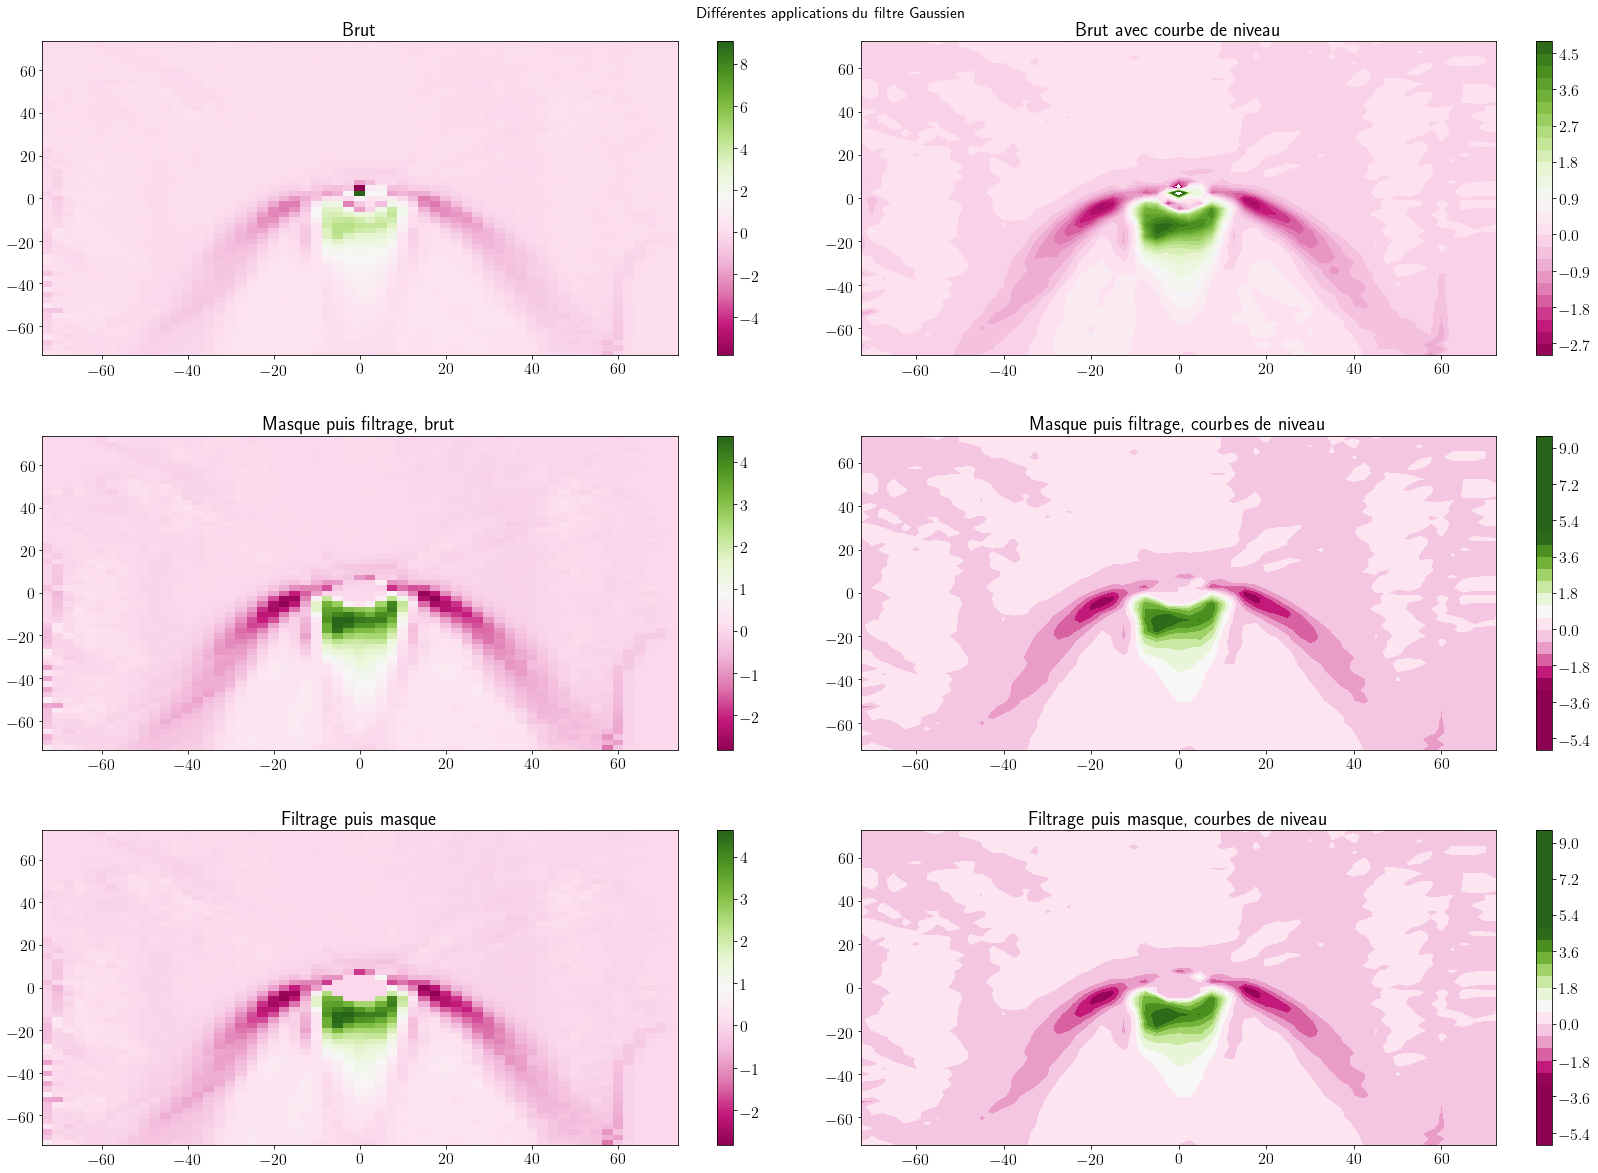

In [21]:
#%matplotlib notebook
plt.rcParams['figure.figsize'] = [24,17]
plot_applications_filtre(div_filter0,div_filter1,div_filter2,'Différentes applications du filtre Gaussien')


La présence du masque est déterminante comme on l'avait vu plus tôt, mais la différence entre l'application du filtre avant ou après n'est pour l'instant pas significative.

### Application de différents sigmas

Je choisis de l'appliquer pour les 2 ordres d'application du masque et du filtrage

#### Dans l'ordre "masque puis filtrage"

Constitution des tableaux : 

In [22]:
#choix des différents sigmas
sigmas=np.arange(0,2,0.5)
n=np.size(sigmas)

#constitution du tableau de filtres
Filtres0=Filtres(sigmas,div,0)#order = 0 pour le masque d'abord 



Plots :

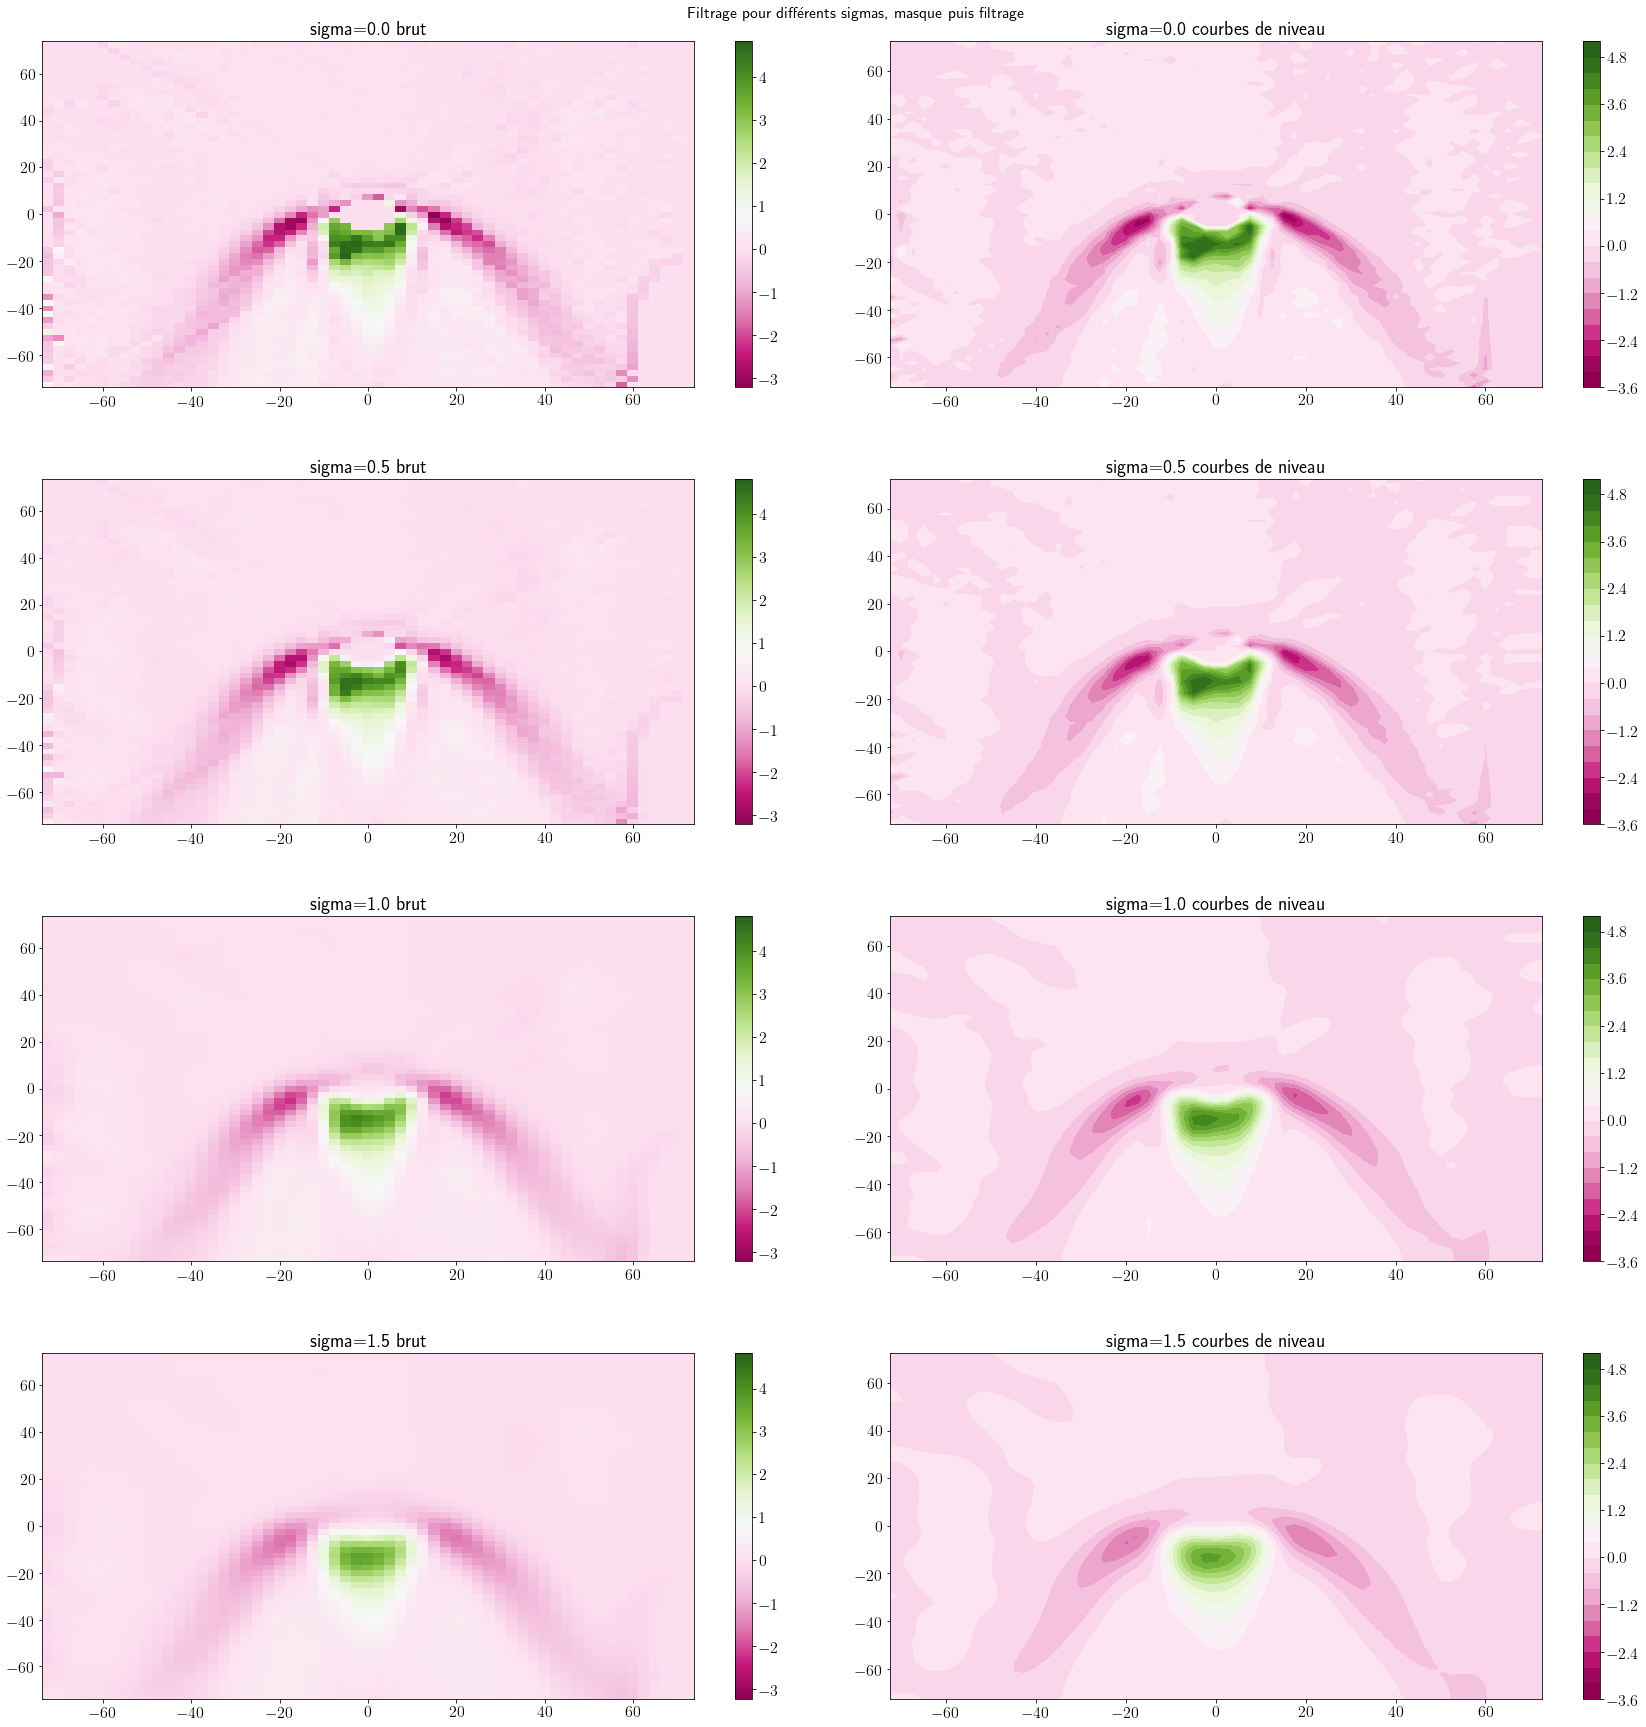

In [23]:
#%matplotlib notebook
#on va essayer de garder un n=4 pour des raisons de praticité 
plt.rcParams['figure.figsize'] = [25,25]
plot_differents_filtrages(Filtres0,sigmas,n,"Filtrage pour différents sigmas, masque puis filtrage")

#### Dans l'ordre "filtrage puis masque"

Constitution des tableaux :

In [24]:
Filtres1=Filtres(sigmas,div,1)#création du tableau de tableau, order = 1 pour filtre puis masque

print(sigmas)   
print("n={}".format(n))

[0.  0.5 1.  1.5]
n=4


Plots :

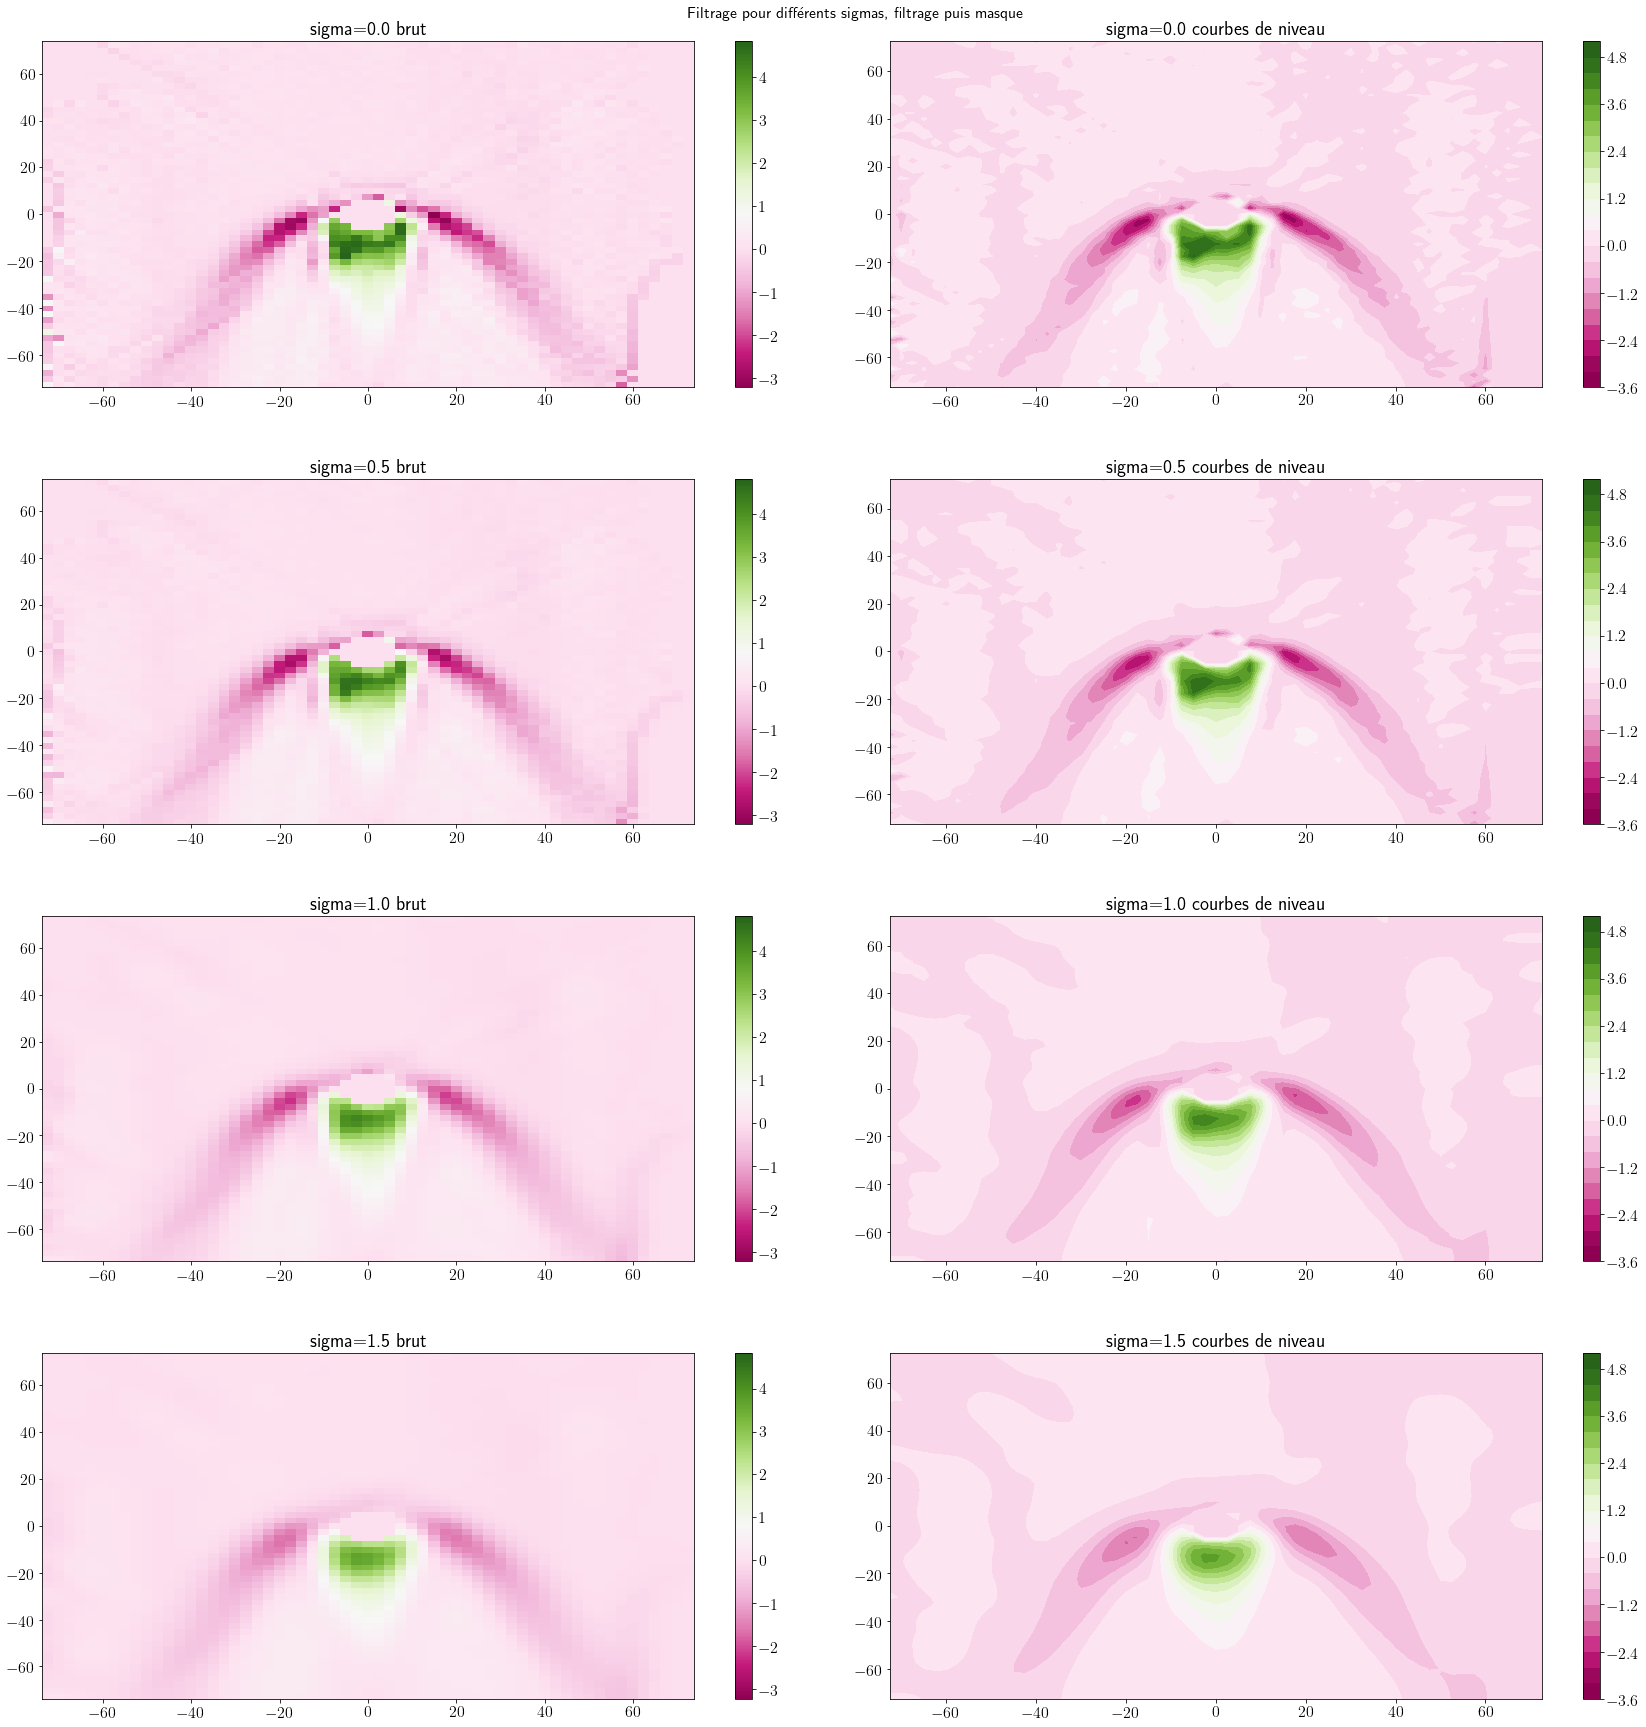

In [25]:
#%matplotlib notebook
plt.rcParams['figure.figsize'] = [25,25]
plot_differents_filtrages(Filtres1,sigmas,n,"Filtrage pour différents sigmas, filtrage puis masque") 

## Application du filtre avant la divergence
### Définition des fonctions
#### Fonctions d'analyse

In [26]:
def dUfiltre(Ufiltre,x,axis):
    "Dérive et remet à la bonne taille donne un tableau (l,n-1,n-1)"
    l=np.shape(Ufiltre)[0]
    n=np.shape(Ufiltre)[1]
    dU=np.zeros((l,n-1,n-1))
    for i in range(l):
        dU[i]=good_shape(deriv(Ufiltre[i], x, axis))
    return(dU)


def somme3D(a,b):
    "somme les tableaux a et b suivant le premier axe"
    S=np.zeros(np.shape(a))
    if np.shape(a)==np.shape(b):
        l=np.shape(a)[0]
        for i in range(l):
            S[i]=a[i]+b[i]
        return(S)
    else:
        return("a et b n'ont pas la même shape")
            

### Constitution des tableaux, comparaisons des sigmas

In [27]:
"Filtrage tableaux de départ"
Ufiltre0=Filtres(sigmas,u,0)#masque puis filtre
Ufiltre1=Filtres(sigmas,u,1)#filtre puis masque
Vfiltre0=Filtres(sigmas,v,0)
Vfiltre1=Filtres(sigmas,v,1)
Ufiltre2=Filtres(sigmas,u,2)#masque en dernier
Vfiltre2=Filtres(sigmas,v,2)#masque en dernier

"Dérivation"
dUfiltre0=dUfiltre(Ufiltre0, x, 1)
dUfiltre1=dUfiltre(Ufiltre1, x, 1)
dVfiltre0=dUfiltre(Vfiltre0, y, 0)
dVfiltre1=dUfiltre(Vfiltre1, y, 0)
dUfiltre2=dUfiltre(Ufiltre2, x, 1)
dVfiltre2=dUfiltre(Vfiltre2, y, 0)

"somme des tableaux"
div0=somme3D(dUfiltre0,dVfiltre0)#masque puis filtre
div1=somme3D(dUfiltre1,dVfiltre1)#filtre puis masque
div2_nu=somme3D(dUfiltre2,dVfiltre2)#masque en dernier

"masque pour div2"
div2=masque(div2_nu)

### Tracés
#### Masque puis Filtre

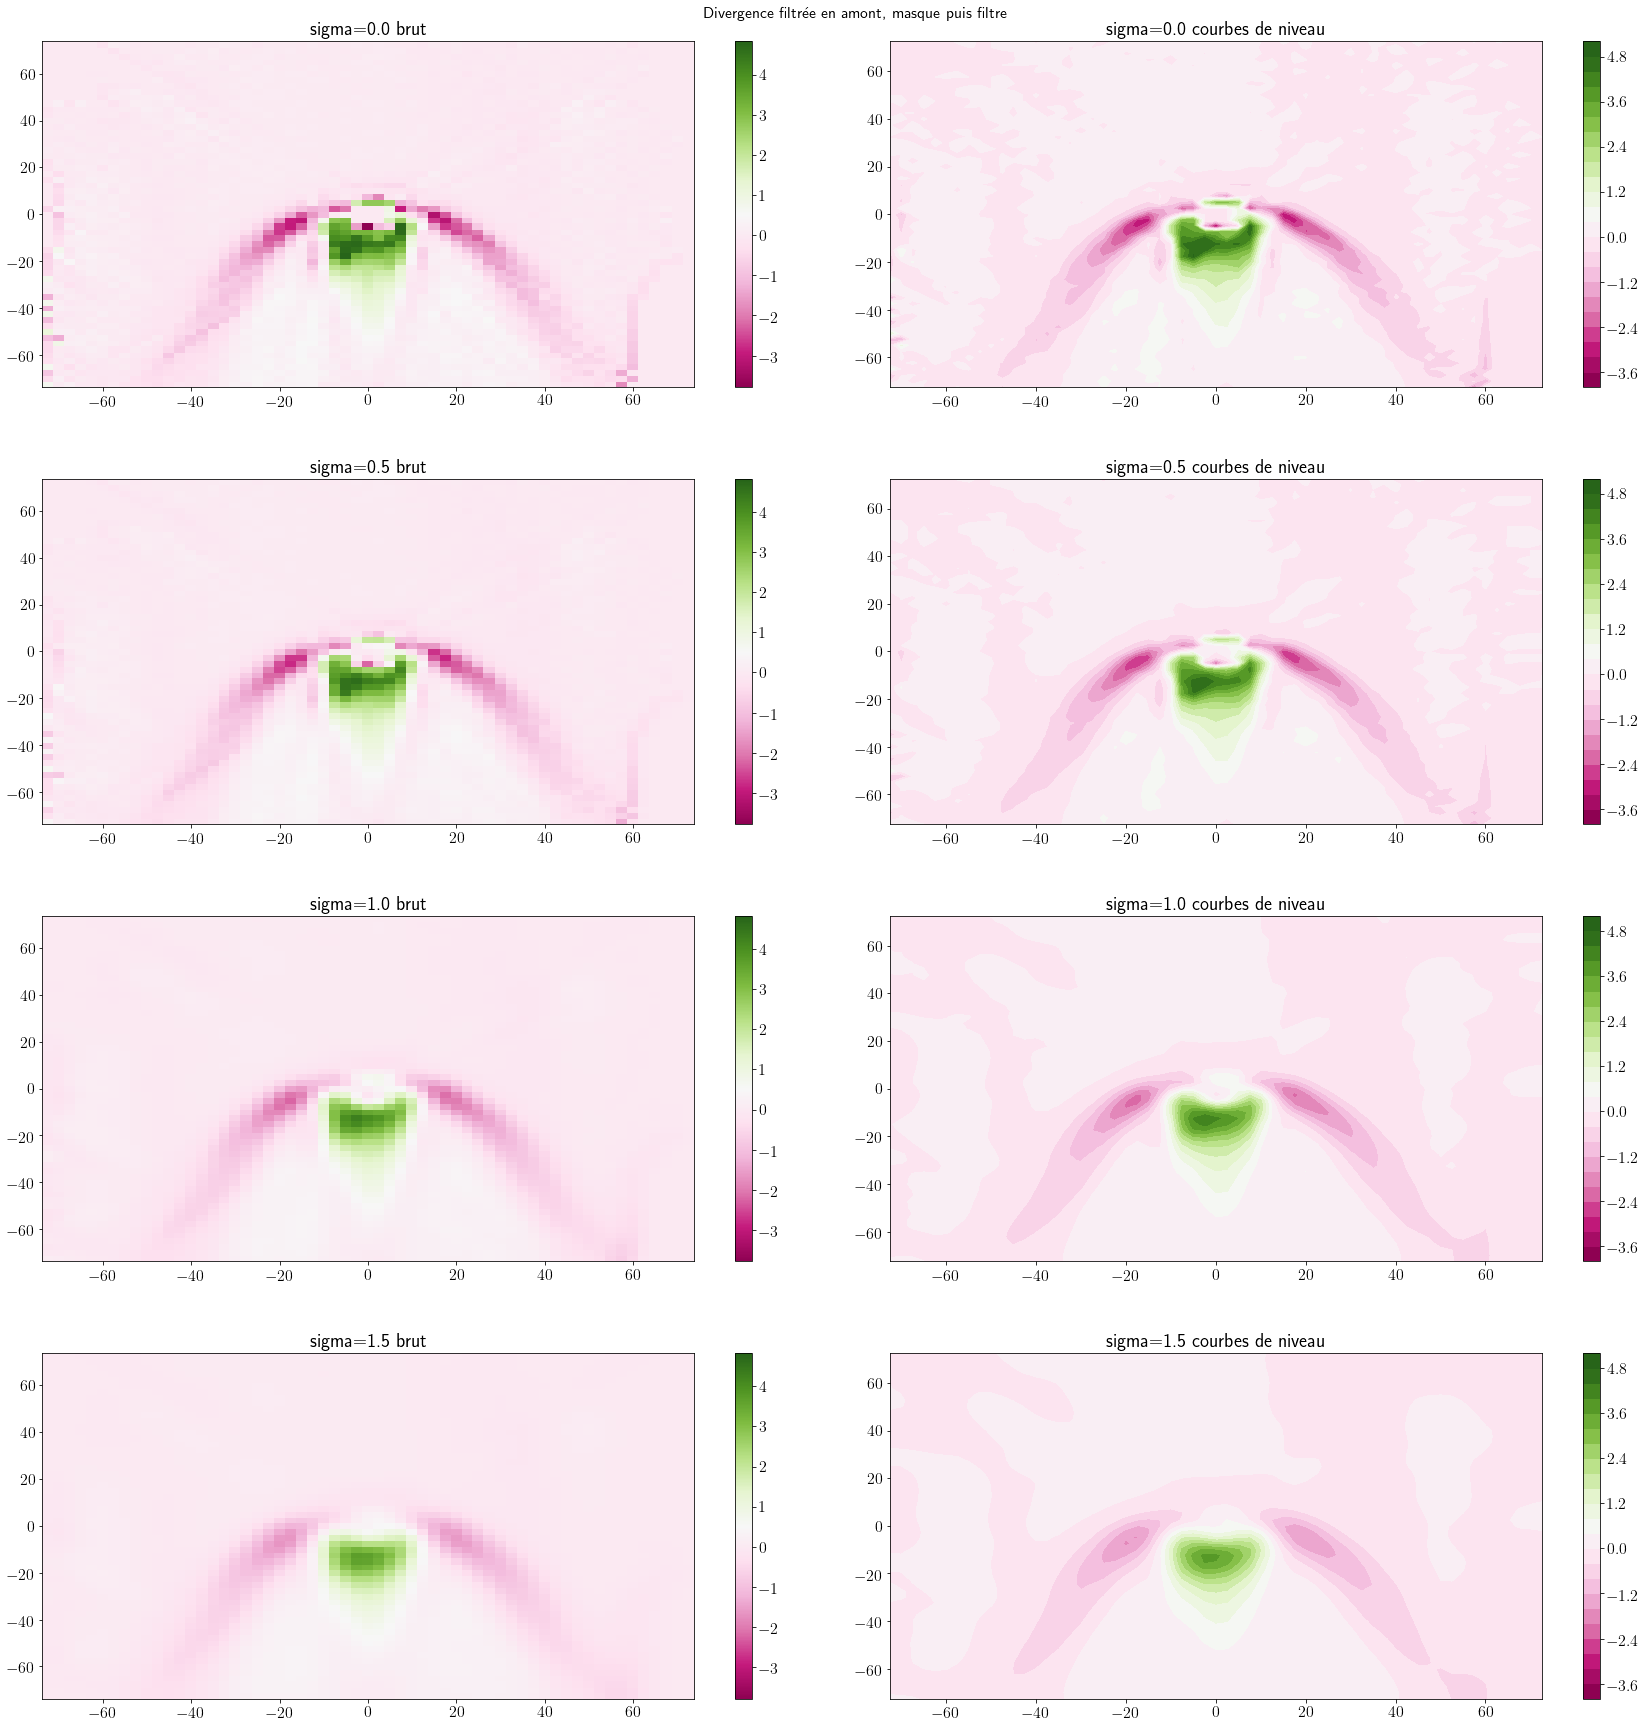

In [28]:
#%matplotlib notebook
plt.rcParams['figure.figsize'] = [25,25]
plot_differents_filtrages(div0,sigmas,n,"Divergence filtrée en amont, masque puis filtre")

#### Filtre puis masque

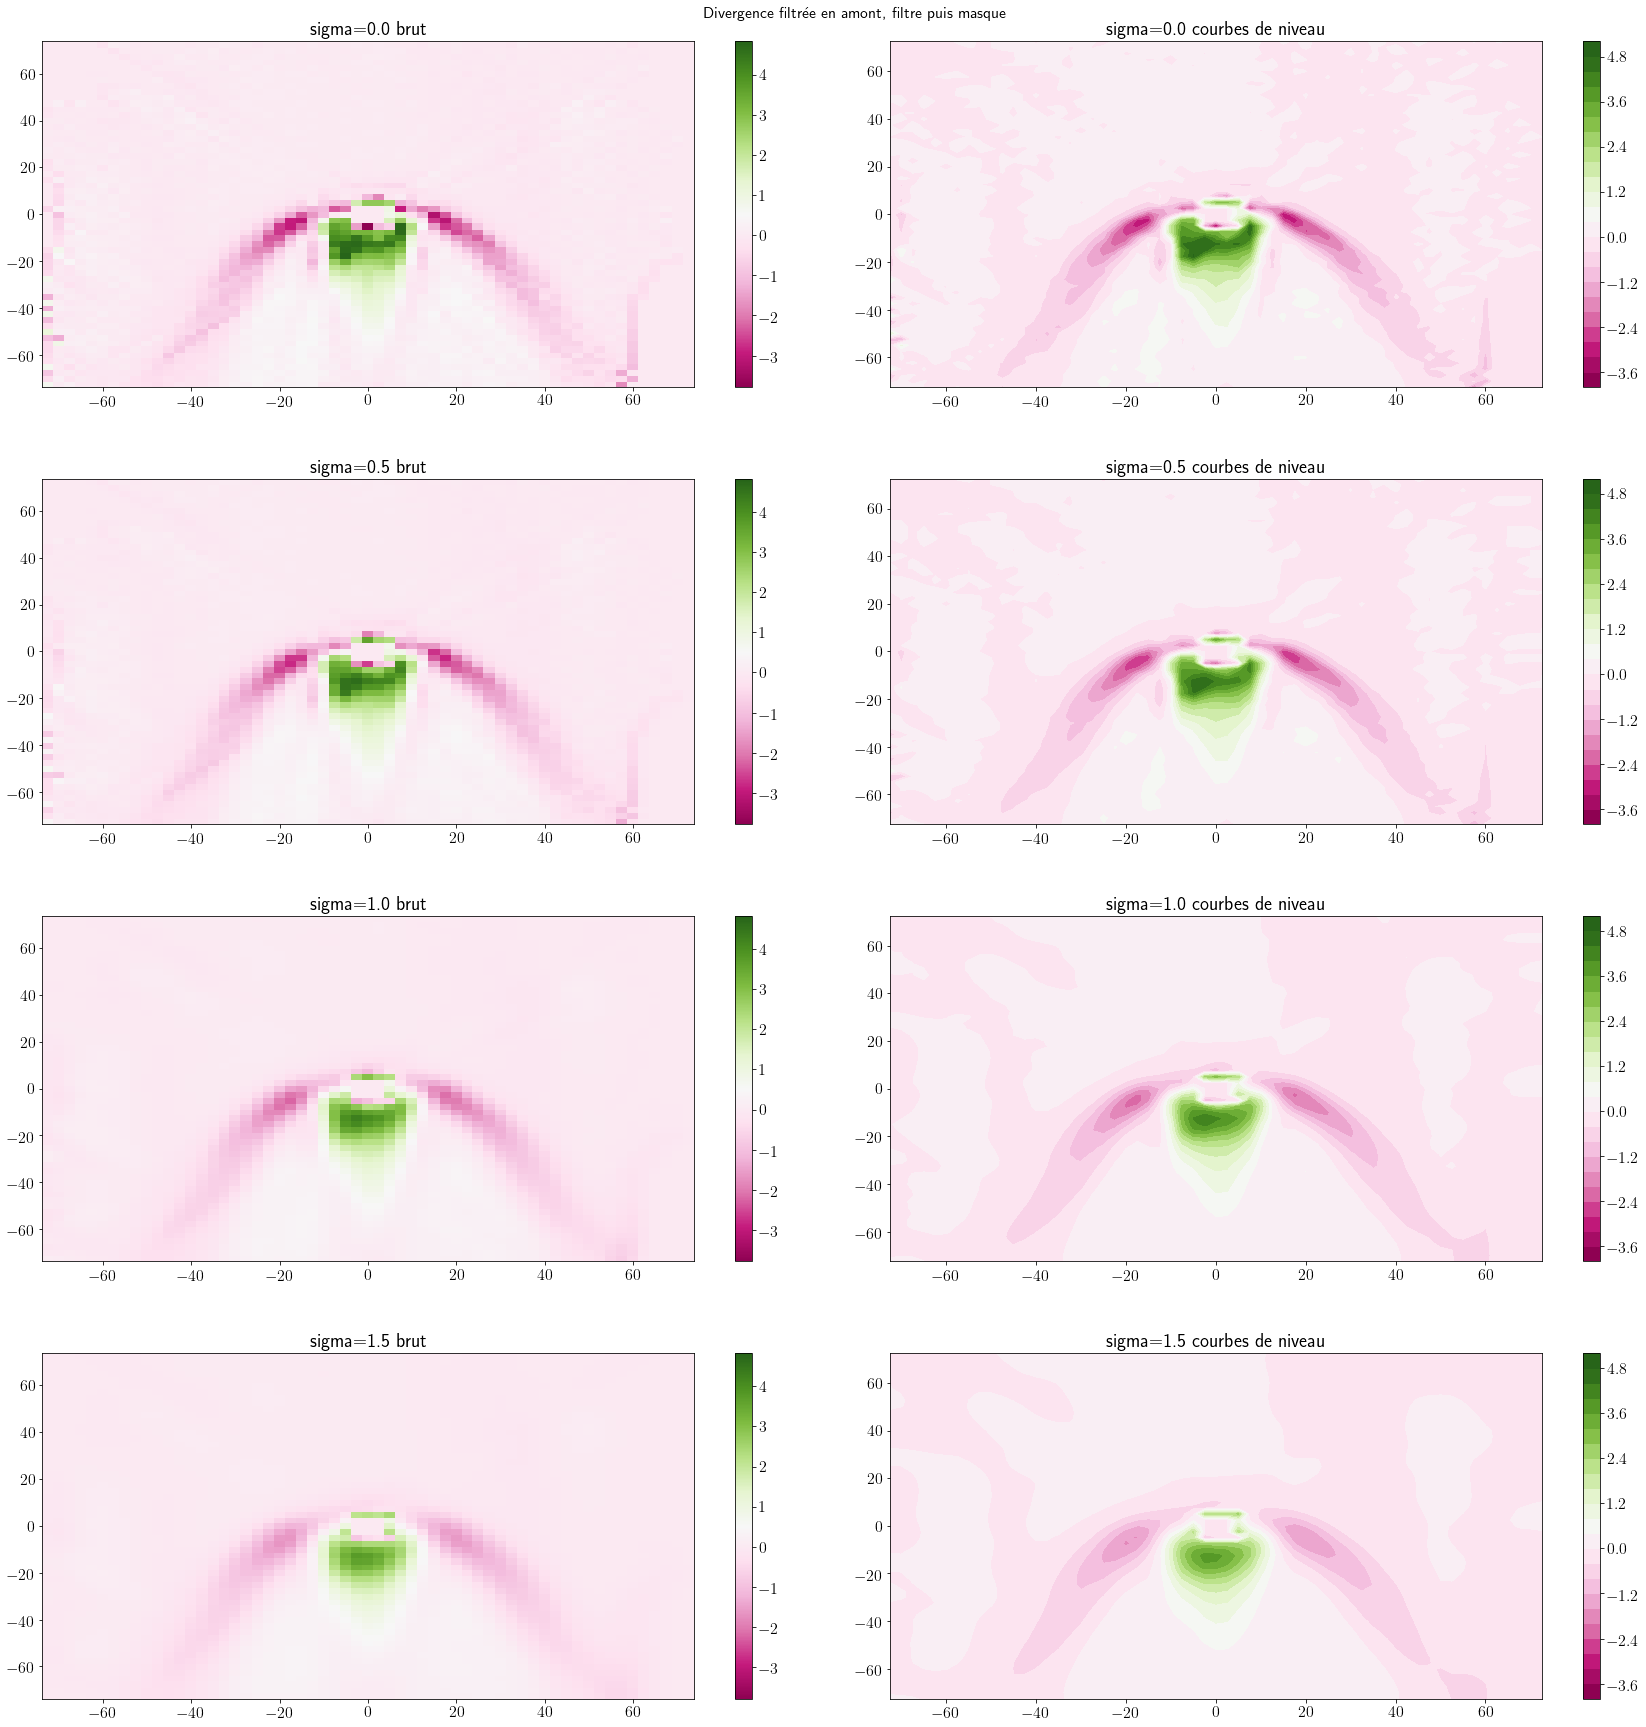

In [29]:
plt.rcParams['figure.figsize'] = [25,25]
plot_differents_filtrages(div1,sigmas,n,"Divergence filtrée en amont, filtre puis masque")

#### Masque en dernier

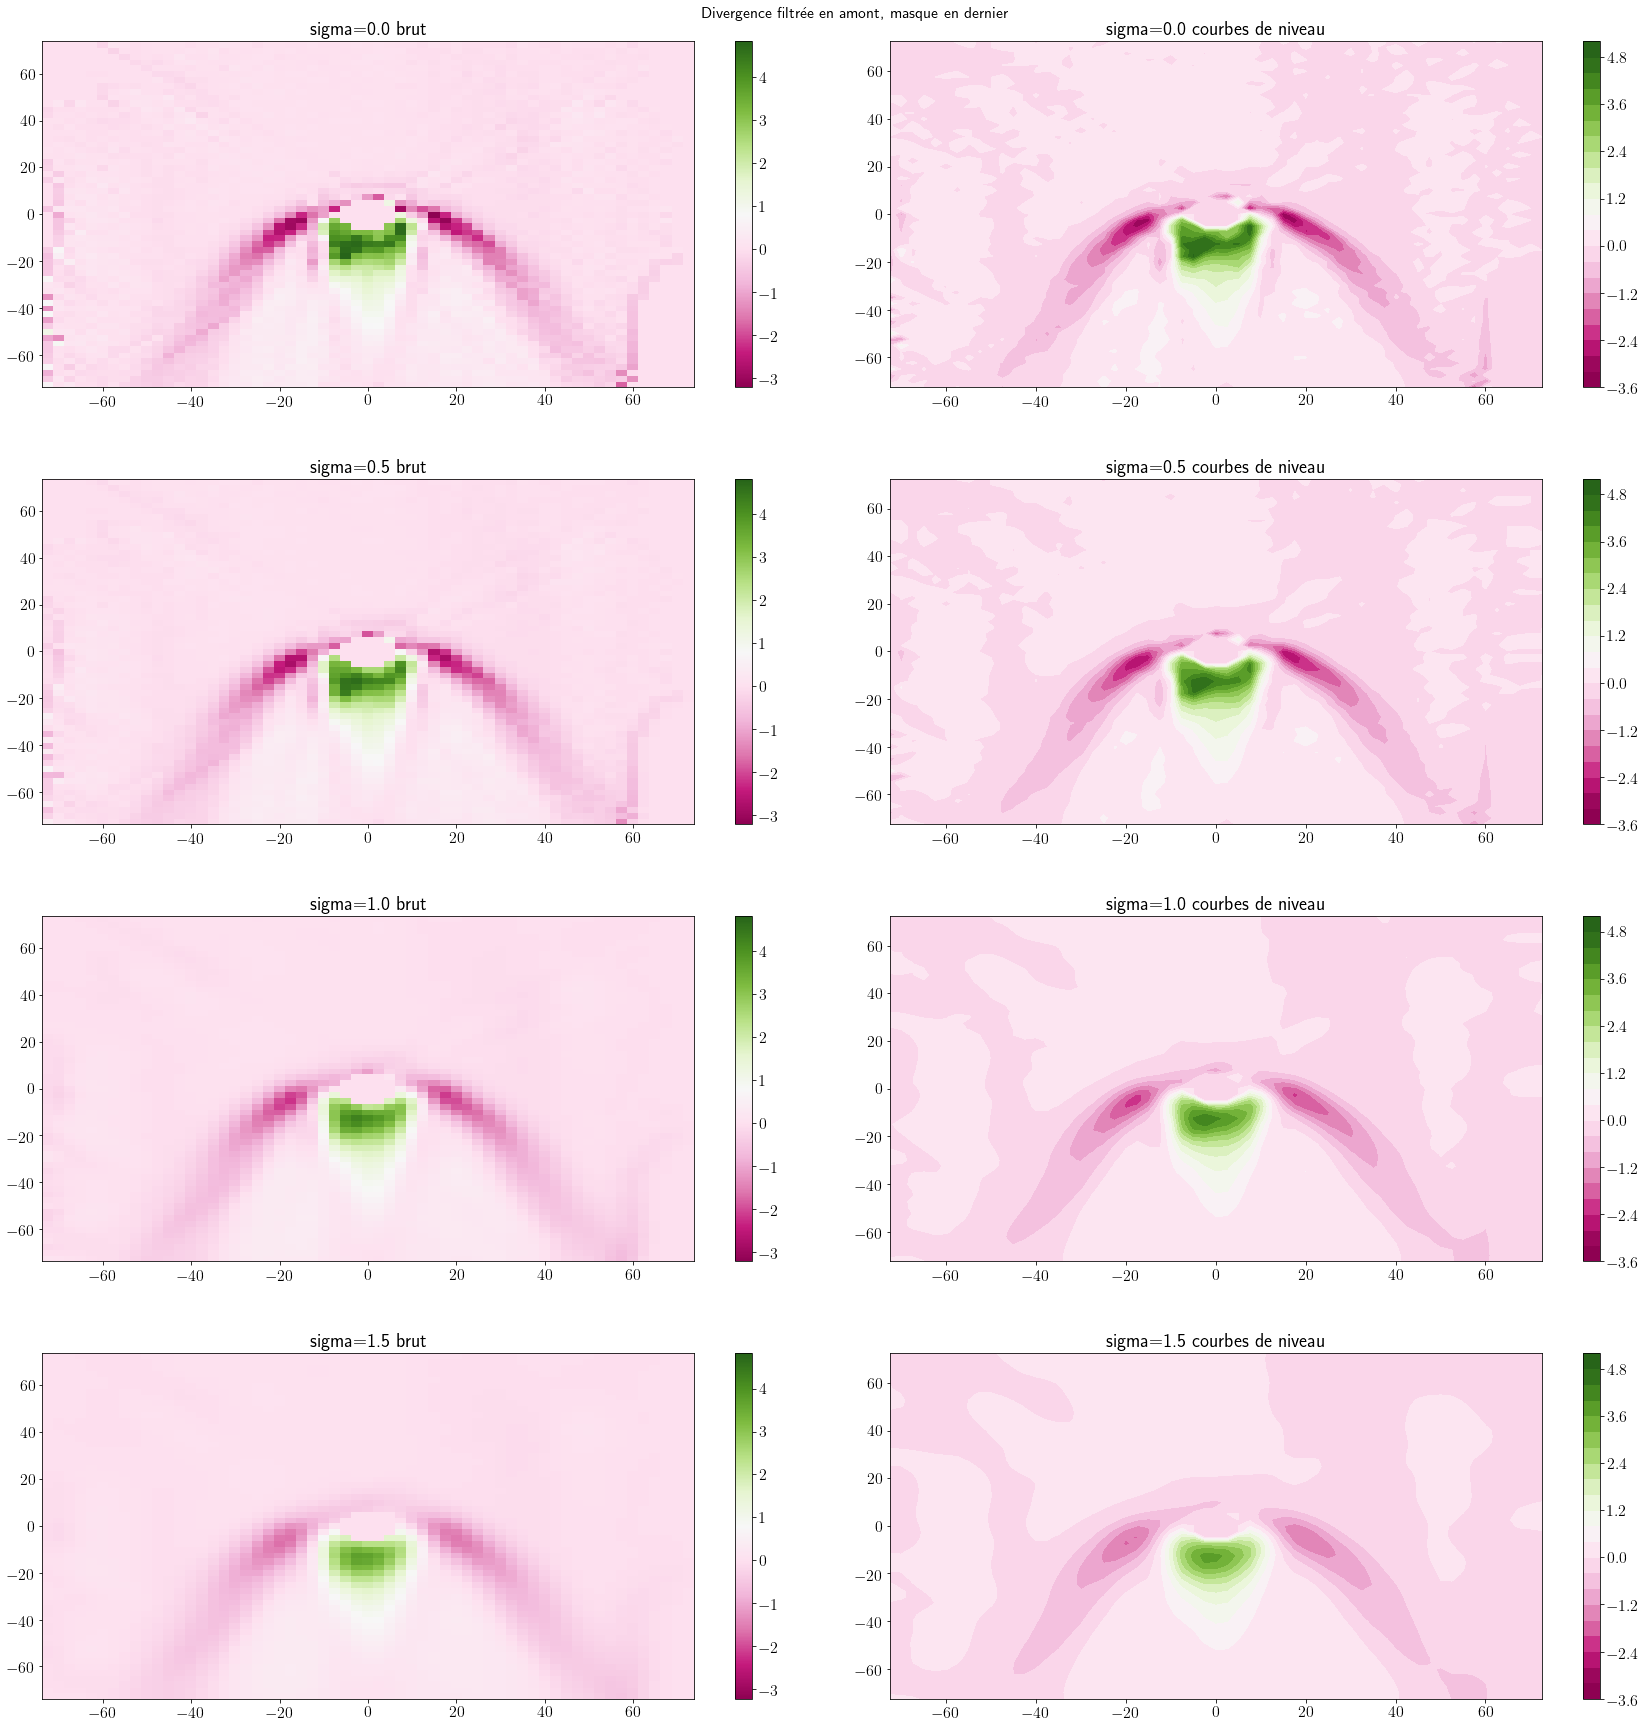

In [30]:
plt.rcParams['figure.figsize'] = [25,25]
plot_differents_filtrages(div2,sigmas,n,"Divergence filtrée en amont, masque en dernier")

## Sigma=1
### définition des fonctions

In [31]:
#fonctions de plot
def plot_sigma1(div0,div1,title):
    "Tracé des divergences pour ordre de filtrage différents, plot 4x4"
    #norme
    extremums=np.array([np.max(div0),np.min(div0),np.max(div1),np.min(div1)])
    vmax,vmin=np.max(extremums),np.min(extremums)
    norm=Normalize(vmin=vmin, vmax=vmax)
    levels = MaxNLocator(nbins=25).tick_values(vmin,vmax)
    
    fig, (l0,l1) = plt.subplots(nrows=2,ncols=2,num=title)
    #l0
    im0=l0[0].pcolormesh(x,y,div0,cmap=colormap2,norm=norm)
    l0[0].set_title("Filtre avant dérivation, brut")
    fig.colorbar(im0,ax=l0[0])
    im1 = l0[1].contourf(dx,dy,div0,levels=levels, cmap=colormap2,norm=norm)
    l0[1].set_title("Filtre avant dérivation, courbes de niveaux")
    fig.colorbar(im1,ax=l0[1])
    #l1
    im2=l1[0].pcolormesh(x,y,div1,cmap=colormap2,norm=norm)
    l1[0].set_title("Filtre après dérivation, brut")
    fig.colorbar(im2,ax=l1[0])
    im3 = l1[1].contourf(dx,dy,div1,levels=levels, cmap=colormap2,norm=norm)
    l1[1].set_title("Filtre après dérivation, courbes de niveaux")
    fig.colorbar(im3,ax=l1[1])
        
    fig.tight_layout(pad=3.2)
    fig.suptitle(title,fontsize=20)
    plt.show()
    
def plot_sigma_masque(div0,div1,div2,title):
    "Tracé des divergences pour ordre de masquage différents, plot 3x1"
    #norme
    extremums=np.array([np.max(div0),np.min(div0),np.max(div1),np.min(div1),np.max(div2),np.min(div2)])
    vmax,vmin=np.max(extremums),np.min(extremums)
    norm=Normalize(vmin=vmin, vmax=vmax)
    levels = MaxNLocator(nbins=25).tick_values(vmin,vmax)
    
    fig, (l0,l1,l2) = plt.subplots(nrows=3,ncols=1,num=title)
    #l0
    im0 = l0.contourf(dx,dy,div0,levels=levels, cmap=colormap2,norm=norm)
    l0.set_title("Masque puis filtre puis divergence")
    fig.colorbar(im0,ax=l0)
    #l1
    im1 = l1.contourf(dx,dy,div1,levels=levels, cmap=colormap2,norm=norm)
    l1.set_title("Filtre puis masque puis divergence")
    fig.colorbar(im1,ax=l1)
    #l2
    im2 = l2.contourf(dx,dy,div1,levels=levels, cmap=colormap2,norm=norm)
    l2.set_title("Filtre puis divergence puis masque")
    fig.colorbar(im2,ax=l2)
    
        
    fig.tight_layout(pad=3.2)
    fig.suptitle(title,fontsize=20)
    plt.show()
        

### Récupération des données

In [32]:
if sigmas[2]==1 : #sinon aviser avec sigmas
    div0_1=div0[2] #filtre avant div, masque puis filtre
    div1_1=div1[2] # filtre avant div, filtre puis masque
    div2_1=div2[2] #filtre avant div, masque en dernier
    filtre0_1=Filtres0[2] #filtre après div, masque puis filtre
    filtre1_1=Filtres1[2] #filtre après div, filtre puis masque

### plots
#### Masque puis filtre

Comparaison de l'ordre entre filtrage et dérivation, pour un masque appliqué avant le filtrage

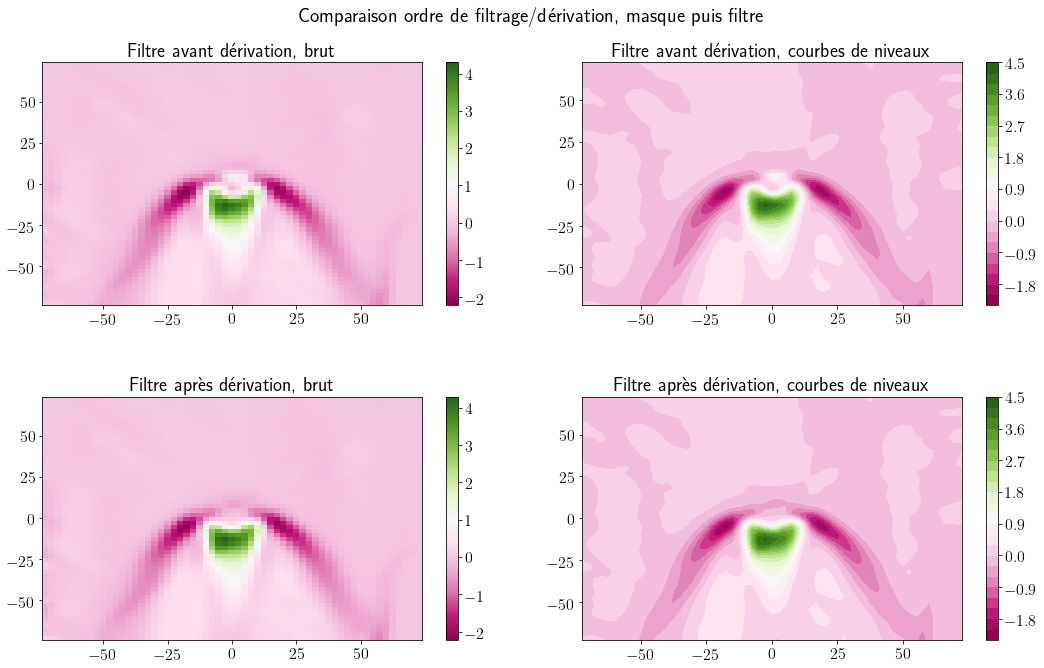

In [33]:
plt.rcParams['figure.figsize'] = [16,10]
plot_sigma1(div0_1,filtre0_1,"Comparaison ordre de filtrage/dérivation, masque puis filtre")

#### Filtre puis masque

Comparaison de l'ordre entre filtrage et dérivation, pour un masque appliqué après le filtrage

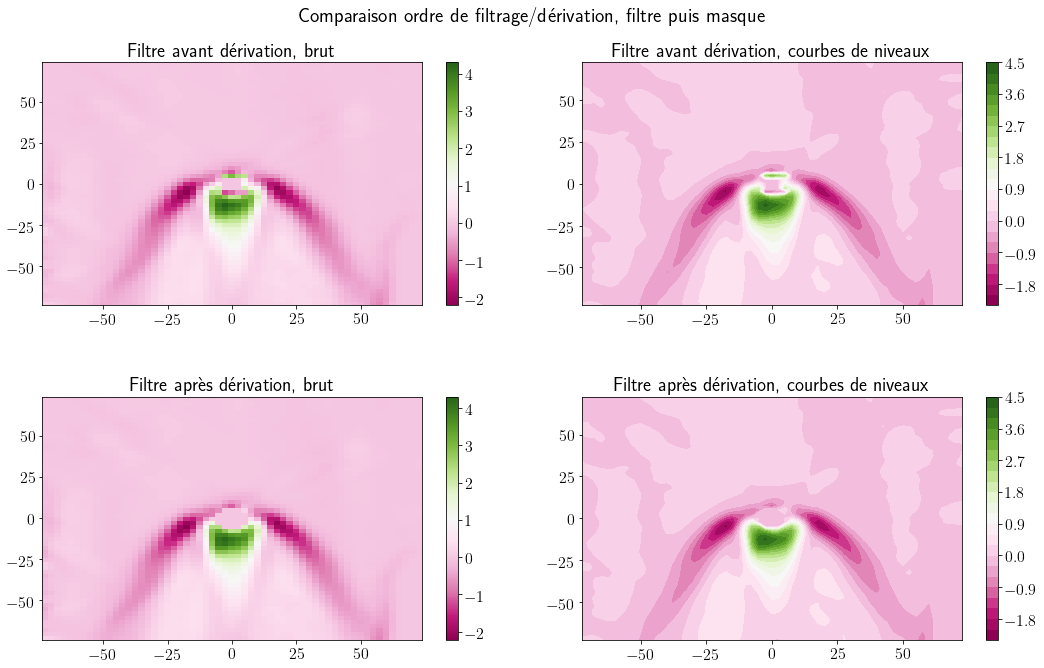

In [34]:
#%matplotlib notebook
plt.rcParams['figure.figsize'] = [16,10]
plot_sigma1(div1_1,filtre1_1,"Comparaison ordre de filtrage/dérivation, filtre puis masque")

#### Position du masque

Comparaison des résultats pour l'ordre filtrage puis divergence pour différentes positions du masque.

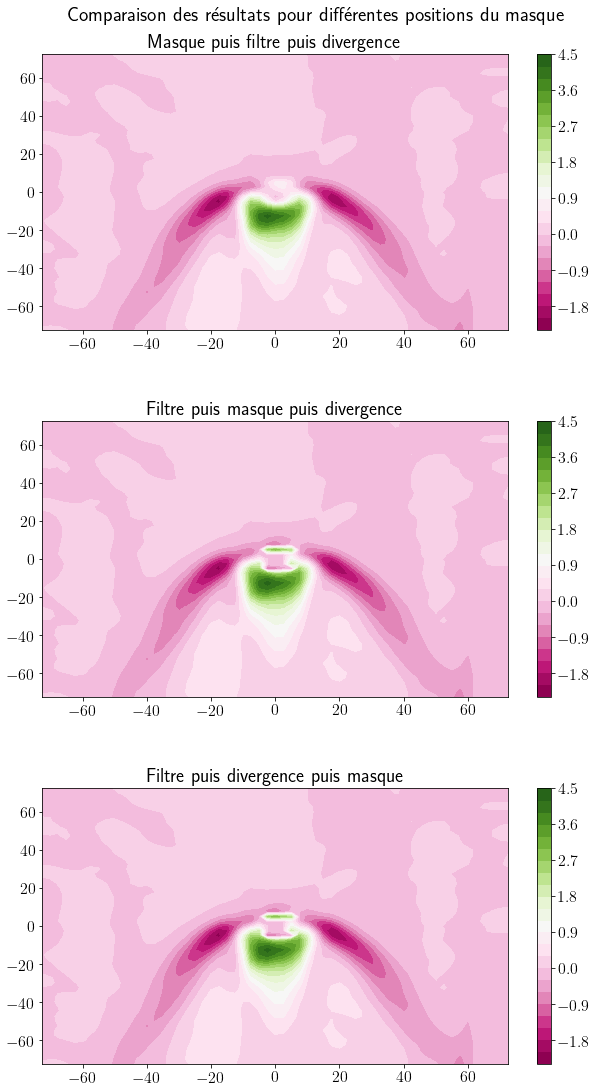

In [35]:
plt.rcParams['figure.figsize'] = [10,16]
plot_sigma_masque(div0_1,div1_1,div2_1,"Comparaison des résultats pour différentes positions du masque")

## Superposition des vitesses
### Définition des fonctions

In [36]:
#fonction de plot

def plot_superposition (div0,div1,title,m):
    "Tracé des divergences et champ pour ordre de filtrage différents"
    #norme
    extremums=np.array([np.max(div0),np.min(div0),np.max(div1),np.min(div1)])
    vmax,vmin=np.max(extremums),np.min(extremums)
    norm=Normalize(vmin=vmin, vmax=vmax)
    levels = MaxNLocator(nbins=25).tick_values(vmin,vmax)
    colors = velocity
    if m==2:
        fig, (l0,l1) = plt.subplots(nrows=2,ncols=1,num=title)
        #l0
        im0 = l0.contourf(dx,dy,div0,levels=levels, cmap=colormap2,norm=norm)
        l0.set_title("Filtre avant dérivation")
        fig.colorbar(im0,ax=l0)
        im1=l0.quiver(x[::2,::2],y[::2,::2],u[::2,::2]/velocity[::2,::2],v[::2,::2]/velocity[::2,::2],colors[::2,::2])
        fig.colorbar(im1, ax=l0)
        #l1
        im2 = l1.contourf(dx,dy,div1,levels=levels, cmap=colormap2,norm=norm)
        l1.set_title("Filtre après dérivation")
        fig.colorbar(im2,ax=l1)
        im3=l1.quiver(x[::2,::2],y[::2,::2],u[::2,::2]/velocity[::2,::2],v[::2,::2]/velocity[::2,::2],colors[::2,::2])
        fig.colorbar(im3, ax=l1) 
        
        
    if m==1:
        fig, l0 = plt.subplots(nrows=1,ncols=1,num=title)
        #l0
        im0 = l0.contourf(dx,dy,div0,levels=levels, cmap=colormap2,norm=norm)
        l0.set_title("Filtre avant dérivation")
        fig.colorbar(im0,ax=l0)
        im1=l0.quiver(x[::2,::2],y[::2,::2],u[::2,::2]/velocity[::2,::2],v[::2,::2]/velocity[::2,::2],colors[::2,::2])
        fig.colorbar(im1, ax=l0)
        
    fig.tight_layout(pad=3.2)
    fig.suptitle(title,fontsize=16)
    plt.show()

### plots
#### Masque puis filtre

C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


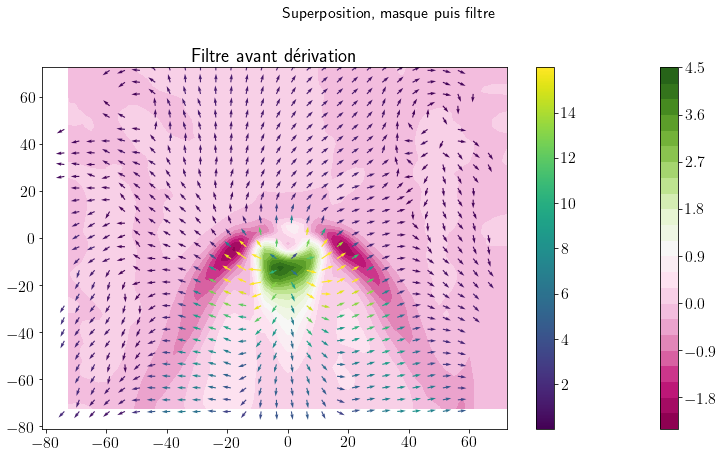

In [37]:
#Choix de n
#m=1 pour juste le plot filtre puis divergence, n=2 sinon
m=1

#ajustement taille figures
if m==1 :
    plt.rcParams['figure.figsize'] = [12,7]
if m==2 : 
    plt.rcParams['figure.figsize'] = [12,10]
    
# plot
plot_superposition(div0_1,filtre0_1,"Superposition, masque puis filtre",m)

#### Filtre puis masque

C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


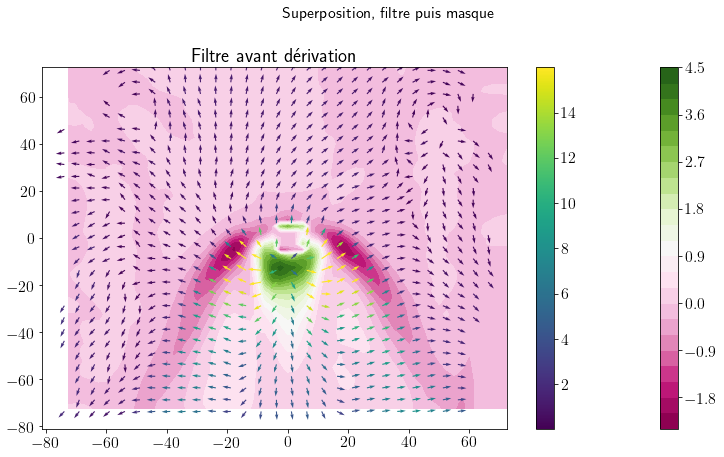

In [38]:
#Choix de n
#m=1 pour juste le plot filtre puis divergence, n=2 sinon
m=1

#ajustement taille figures
if m==1 :
    plt.rcParams['figure.figsize'] = [12,7]
if m==2 : 
    plt.rcParams['figure.figsize'] = [12,10]
    
plot_superposition(div1_1,filtre1_1,"Superposition, filtre puis masque",m)

#### Masque en dernier

C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


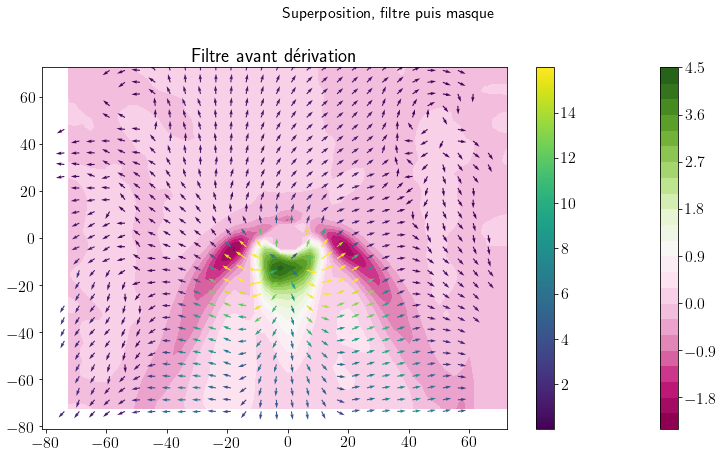

In [39]:
#%matplotlib notebook
plt.rcParams['figure.figsize'] = [12,7]
plot_superposition(div2_1,filtre1_1,"Superposition, filtre puis masque",1)

**Trucs à faire dans un futur plus ou moins proche**

-tenter les lignes de champ

-résoudre problèmes taille flèches en quiver

-résoudre la question de la colormap en quiver

-trouver comment label juste une ligne

-moyen de faire une boucle pour tracer les 1000 subplots ?

-importer notebook ?

-question de la taille du masque

